<a href="https://colab.research.google.com/github/futaoo/kgml-rainfall/blob/main/kgml_rainfal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os, sys
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/My Drive/Colab Notebooks/KGExtension-code/')

Mounted at /content/drive


##Pip Packages

In [2]:
!pip install kgextension

     |████████████████████████████████| 62 kB 1.1 MB/s 
     |████████████████████████████████| 45 kB 4.2 MB/s 
     |████████████████████████████████| 407 kB 22.6 MB/s 
     |████████████████████████████████| 45 kB 3.7 MB/s 


##Scripts

###Imports

In [3]:
import kgextension
import pandas as pd
from kgextension.sparql_helper import RemoteEndpoint
from kgextension.sparql_helper import endpoint_wrapper
from kgextension.linking import label_linker
from kgextension.generator import data_properties_generator
from kgextension.generator import unqualified_relation_generator
from kgextension.generator import specific_relation_generator
from kgextension.generator import custom_sparql_generator
from kgextension.linking import dbpedia_spotlight_linker
from kgextension.link_exploration import link_explorer
from kgextension.uri_helper import uri_querier
from kgextension.endpoints import DBpedia


from pandas import DataFrame
from pandas import concat


from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np

import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

from sklearn.svm import SVC

from sklearn.neural_network import MLPClassifier

from sklearn.neighbors import KNeighborsClassifier

###Functions

In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


def prcp_map(x):
    value = 'yes' if x > 0 else 'no'
    return value

###Prepare Data

In [ ]:
climate_kg = RemoteEndpoint(url = "http://jresearch.ucd.ie/kg/climate/sparql", timeout=120, requests_per_min=100*60, retries=10, page_size=10000)

In [ ]:
query_obsv = 'PREFIX ca-property: <http://jresearch.ucd.ie/climate-kg/ca/property/> PREFIX sosa: <http://www.w3.org/ns/sosa/> PREFIX xsd: <http://www.w3.org/2001/XMLSchema#> SELECT ?obsv WHERE {?obsv ca-property:sourceStation <http://jresearch.ucd.ie/climate-kg/resource/station/GHCND:EI000003969>; sosa:resultTime ?date. FILTER ((?date>="2019-04-01"^^xsd:date)&&(?date<="2021-04-01"^^xsd:date))}'
df_entities = endpoint_wrapper(endpoint=climate_kg, query=query_obsv)
query_features= 'PREFIX ca-property: <http://jresearch.ucd.ie/climate-kg/ca/property/> PREFIX sosa: <http://www.w3.org/ns/sosa/> SELECT  ?station ?simpleresult  ?date ?datatype WHERE { *obsv* sosa:hasSimpleResult ?simpleresult; sosa:resultTime ?date; ca-property:sourceStation ?station; sosa:hasResult/ca-property:withDataType/ca-property:id ?datatype. }'
df_custom_sparql = custom_sparql_generator(df_entities, "obsv", query_features, endpoint=climate_kg)
df_custom_sparql

In [ ]:
df_custom_sparql.to_csv('./datasets/climate-features-plus.csv')

In [6]:
df_climate = pd.read_csv('./datasets/climate-features.csv').pivot(index='date', columns='datatype', values='simpleresult').fillna(0)
df_climate


datatype,PRCP,SNWD,TAVG,TMAX,TMIN
date,,,,,
2019-06-01,1.2,0.0,13.3,20.0,7.5
2019-06-02,0.0,0.0,14.9,19.3,13.6
2019-06-03,9.3,0.0,11.5,17.2,8.6
2019-06-04,19.7,0.0,10.4,12.4,7.9
2019-06-05,0.3,0.0,9.9,12.6,8.8
...,...,...,...,...,...
2020-05-28,0.0,0.0,15.3,23.3,10.1
2020-05-29,0.0,0.0,15.8,23.5,11.3
2020-05-30,0.0,0.0,14.9,22.0,9.2


In [8]:
df_refined = df_climate.drop(columns=['SNWD','TMAX','TMIN'])
df_refined

datatype,PRCP,TAVG
date,,
2019-06-01,1.2,13.3
2019-06-02,0.0,14.9
2019-06-03,9.3,11.5
2019-06-04,19.7,10.4
2019-06-05,0.3,9.9
...,...,...
2020-05-28,0.0,15.3
2020-05-29,0.0,15.8
2020-05-30,0.0,14.9


In [ ]:
values = df_refined.values
values

###Create the supervised dataset

In [13]:
df_raw = series_to_supervised(values,2,1).drop(columns='var2(t)')
df_raw

,var1(t-2),var2(t-2),var1(t-1),var2(t-1),var1(t)
2,1.2,13.3,0.0,14.9,9.3
3,0.0,14.9,9.3,11.5,19.7
4,9.3,11.5,19.7,10.4,0.3
5,19.7,10.4,0.3,9.9,0.2
6,0.3,9.9,0.2,10.2,0.0
...,...,...,...,...,...
362,0.0,14.8,0.0,13.9,0.0
363,0.0,13.9,0.0,15.3,0.0
364,0.0,15.3,0.0,15.8,0.0
365,0.0,15.8,0.0,14.9,0.0


###Rainfall detection

####Create training set

In [14]:
df_raw['var1(t)'] = df_raw['var1(t)'].map(prcp_map)
label_binarizer = preprocessing.LabelBinarizer()
y = label_binarizer.fit_transform(df_raw['var1(t)']).ravel()
X = df_raw.drop(columns='var1(t)')
X_train, X_test, y_train, y_test =  train_test_split(X,y, test_size=0.33, stratify=y, random_state=42)

####Build the model

####Random Forest Classifier

              precision    recall  f1-score   support

          no       0.51      0.54      0.52        50
         yes       0.66      0.63      0.65        71

    accuracy                           0.60       121
   macro avg       0.59      0.59      0.59       121
weighted avg       0.60      0.60      0.60       121



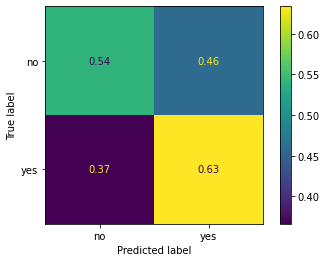

In [15]:
clf = RandomForestClassifier(random_state=1235).fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, target_names=label_binarizer.classes_))
ConfusionMatrixDisplay(confusion_matrix=confusion_matrix(y_test, y_pred, normalize="true"), display_labels=label_binarizer.classes_).plot()
plt.show()